# EvolveGCN Implementation for Elliptic Dataset

This notebook implements **EvolveGCN (Evolving Graph Convolutional Networks)** to detect illicit transactions in the Elliptic Bitcoin dataset. 

We will implement and compare two variants:
1.  **EvolveGCN-O (Output/Trend-Aware)**: Evolves weights based on the *previous weight matrix*. It captures the *trend* of model evolution.
2.  **EvolveGCN-H (Hidden/Structure-Aware)**: Evolves weights based on the *current graph structure*. It captures the *context* of the graph.

## Why EvolveGCN?
Unlike sequential fine-tuning (which "chases" the data), EvolveGCN uses an RNN to *predict* the optimal weights for the next timestep, allowing it to adapt to dynamic changes more effectively.

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_max_pool
from torch.nn.parameter import Parameter
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import time

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Data Loading and Preprocessing
We reuse the standard preprocessing steps for the Elliptic dataset.

In [49]:
# Load Data
print("Loading data...")
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

# Rename feature columns
features_df.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(165)]

# Map classes: 'unknown'=0, '1'=1 (illicit), '2'=2 (licit)
classes_df['class'] = classes_df['class'].map({'unknown': 0, '1': 1, '2': 2})

# Merge
df = features_df.merge(classes_df, on='txId', how='left')

# Node Mapping
node_ids = df['txId'].values
node_id_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}

# Edges
edge_list = []
for _, row in edgelist_df.iterrows():
    if row['txId1'] in node_id_to_idx and row['txId2'] in node_id_to_idx:
        edge_list.append([node_id_to_idx[row['txId1']], node_id_to_idx[row['txId2']]])
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Tensors
x = torch.tensor(df.iloc[:, 2:-1].values, dtype=torch.float)
y = torch.tensor(df['class'].values, dtype=torch.long)
time_steps = torch.tensor(df['time_step'].values, dtype=torch.long)

print("Data loaded successfully.")

Loading data...
Data loaded successfully.


## 2. EvolveGCN-O Implementation (Trend-Aware)

### Understanding the RNN Cell: MatGRU vs. Standard GRU

In EvolveGCN, we treat the GCN weights as the "hidden state" of an RNN. However, GCN weights are **matrices** (e.g., `Input_Dim x Hidden_Dim`), whereas standard RNNs expect **vectors**.

We have two choices:
1.  **Standard GRU (Vector-to-Vector)**: Flatten the weight matrix into a long vector. 
    *   *Pros*: Simple to implement using `torch.nn.GRUCell`.
    *   *Cons*: Loses the spatial structure of the weight matrix (rows vs. columns). Extremely high parameter count for the RNN if the matrix is large.
2.  **MatGRU (Matrix-to-Matrix)**: Process the weight matrix directly without flattening.
    *   *Pros*: Preserves the structural information (input features vs. output features). More parameter-efficient as it shares weights across rows/columns.
    *   *Cons*: Requires custom implementation.

**For EvolveGCN, we use MatGRU.** It treats each column of the weight matrix as a separate "feature vector" and applies the same GRU update rule to all columns in parallel. This allows the RNN to learn how *feature transformations* evolve over time.

In [50]:
class MatGRUCell(nn.Module):
    """
    GRU Cell that operates on Matrices (MatGRU).
    
    Standard GRU:  h_t = GRU(x_t, h_{t-1})  where x, h are vectors.
    MatGRU:        W_t = GRU(X_t, W_{t-1})  where X, W are matrices.
    
    We implement this by treating each row of W as a separate sequence element,
    applying GRU updates independently to each row.
    """
    def __init__(self, hidden_size):
        super().__init__()
        # GRU operates on each row independently
        # Input and hidden size are both hidden_size (the number of columns in W)
        self.gru = nn.GRUCell(hidden_size, hidden_size)

    def forward(self, prev_W, inputs=None):
        """
        prev_W: Weight matrix from previous timestep [in_feats, hidden_size]
        inputs: Optional input matrix [in_feats, hidden_size] (for EvolveGCN-H)
                If None, uses zeros (for EvolveGCN-O)
        
        Returns: Updated weight matrix [in_feats, hidden_size]
        """
        # For EvolveGCN-O: no external input, evolve based on previous state
        if inputs is None:
            inputs = torch.zeros_like(prev_W)
        
        # Apply GRU to each row independently
        # prev_W: [in_feats, hidden_size] treated as batch of in_feats vectors
        # Each vector has hidden_size elements
        out = self.gru(inputs, prev_W)
        
        return out

In [51]:
class EvolveGCN_O(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes):
        super().__init__()
        
        # Evolution RNNs - now using correct dimensions
        self.recurrent_1 = MatGRUCell(n_hidden)
        self.recurrent_2 = MatGRUCell(n_classes)
        
        # Initial Weights (Hidden State)
        self.W1 = Parameter(torch.Tensor(in_feats, n_hidden))
        self.W2 = Parameter(torch.Tensor(n_hidden, n_classes))
        
        # GCN Layers (We will use these for message passing, but inject our weights)
        self.conv1 = GCNConv(in_feats, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_classes)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)

    def forward(self, x, edge_index):
        # 1. Evolve Weights
        # W_t = GRU(W_{t-1})
        new_W1 = self.recurrent_1(self.W1)
        new_W2 = self.recurrent_2(self.W2)
        
        # Update internal state for next timestep
        self.W1 = Parameter(new_W1)
        self.W2 = Parameter(new_W2)
        
        # 2. Inject Weights into GCN Layers
        # PyG GCNConv stores weights in .lin.weight (if bias=True) or .weight
        # Note: PyG weights are usually Transposed [Out, In]. Our W is [In, Out].
        self.conv1.lin.weight.data = new_W1.t()
        self.conv2.lin.weight.data = new_W2.t()
        
        # 3. Forward Pass
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        return x

In [52]:
# Helper Functions
def compute_class_weights(labels, device):
    n_illicit = (labels == 1).sum().float()
    n_licit = (labels == 2).sum().float()
    total = len(labels)
    
    if n_illicit == 0: weight_illicit = 1.0
    else: weight_illicit = total / (2.0 * n_illicit)
        
    if n_licit == 0: weight_licit = 1.0
    else: weight_licit = total / (2.0 * n_licit)
        
    # Class 0 (unknown) is usually ignored or weighted 1.0
    return torch.tensor([1.0, weight_illicit, weight_licit], dtype=torch.float).to(device)

@torch.no_grad()
def evaluate(model, x, edge_index, mask, y):
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    y_true = y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    # Binary metrics (1=illicit)
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)
    
    return {
        'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0)
    }

In [53]:
# Training Setup
ILLICIT_THRESHOLD = 25
valid_timesteps = []
for t in range(1, 50):
    n_illicit = ((time_steps == t) & (y == 1)).sum().item()
    if n_illicit >= ILLICIT_THRESHOLD:
        valid_timesteps.append(t)

# Split
split_idx = int(len(valid_timesteps) * 0.7)
train_timesteps = valid_timesteps[:split_idx]
test_timesteps = valid_timesteps[split_idx:]

print(f"Train Steps: {len(train_timesteps)}, Test Steps: {len(test_timesteps)}")

model = EvolveGCN_O(in_feats=x.shape[1], n_hidden=64, n_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move data to device
x = x.to(device)
edge_index = edge_index.to(device)
y = y.to(device)
time_steps = time_steps.to(device)

Train Steps: 24, Test Steps: 11


Starting EvolveGCN-O Training...
Epoch 10/50, Loss: 397.2970
Epoch 20/50, Loss: 339.5427
Epoch 30/50, Loss: 293.3515
Epoch 40/50, Loss: 255.0507
Epoch 50/50, Loss: 223.9886

Evaluating on Test Set...
T34: F1=0.1042, Recall=0.1351, Precision=0.0847
T35: F1=0.1543, Recall=0.1374, Precision=0.1761
T36: F1=0.0488, Recall=0.1212, Precision=0.0305
T37: F1=0.2564, Recall=0.2500, Precision=0.2632
T38: F1=0.1646, Recall=0.1171, Precision=0.2766
T39: F1=0.2159, Recall=0.2346, Precision=0.2000
T40: F1=0.1747, Recall=0.1786, Precision=0.1709
T41: F1=0.1004, Recall=0.1034, Precision=0.0976
T42: F1=0.2574, Recall=0.2176, Precision=0.3152
T48: F1=0.3030, Recall=0.2778, Precision=0.3333
T49: F1=0.3333, Recall=0.2679, Precision=0.4412


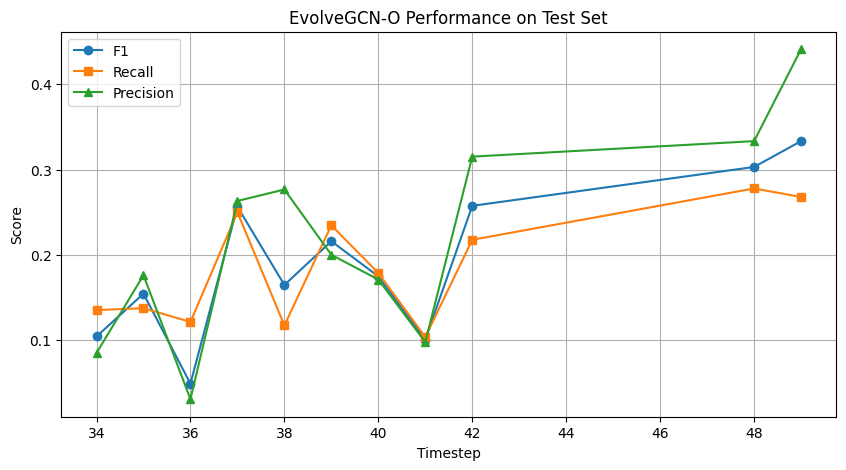

In [54]:
# Training Loop - FIXED
NUM_EPOCHS = 50
results = []

print("Starting EvolveGCN-O Training...")
model.train()

for epoch in range(NUM_EPOCHS):
    # Initialize weights ONCE at the start (not every epoch!)
    if epoch == 0:
        model.reset_parameters()
    
    total_loss = 0
    epoch_start_W1 = model.W1.data.clone()
    epoch_start_W2 = model.W2.data.clone()
    
    # Training Phase - Sequential evolution through timesteps
    for t in train_timesteps:
        current_mask = ((time_steps == t) & (y > 0))
        
        optimizer.zero_grad()
        out = model(x, edge_index)
        
        class_weights = compute_class_weights(y[current_mask], device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        
        loss = criterion(out[current_mask], y[current_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Reset to start of sequence for next epoch
    model.W1.data = epoch_start_W1
    model.W2.data = epoch_start_W2
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss:.4f}")

# Testing Phase
print("\nEvaluating on Test Set...")
model.eval()

# First, evolve through training timesteps to reach the temporal point
# where test data begins
for t in train_timesteps:
    with torch.no_grad():
        _ = model(x, edge_index)

# Now continue evolution through test timesteps
test_results_o = []
for t in test_timesteps:
    current_mask = ((time_steps == t) & (y > 0))
    
    # Evolve and predict
    metrics = evaluate(model, x, edge_index, current_mask, y)
    metrics['timestep'] = t
    test_results_o.append(metrics)
    print(f"T{t}: F1={metrics['f1']:.4f}, Recall={metrics['recall']:.4f}, Precision={metrics['precision']:.4f}")

# Visualization
res_df_o = pd.DataFrame(test_results_o)
plt.figure(figsize=(10, 5))
plt.plot(res_df_o['timestep'], res_df_o['f1'], marker='o', label='F1')
plt.plot(res_df_o['timestep'], res_df_o['recall'], marker='s', label='Recall')
plt.plot(res_df_o['timestep'], res_df_o['precision'], marker='^', label='Precision')
plt.title('EvolveGCN-O Performance on Test Set')
plt.xlabel('Timestep')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### EvolveGCN-O: Pooled Test Set Evaluation

The above metrics are **macro-averaged** (mean across timesteps). For fair comparison to baseline models, we also compute **pooled/micro-averaged** metrics.

In [55]:
# EvolveGCN-O: Pooled Test Set Evaluation (Micro-averaged)
from sklearn.metrics import accuracy_score, roc_auc_score

print("=" * 80)
print("EVOLVEGCN-O: POOLED TEST SET EVALUATION (MICRO-AVERAGED)")
print("=" * 80)

# Create combined test mask for all test timesteps
test_mask_pooled_o = torch.zeros(len(y), dtype=torch.bool).to(device)
for t in test_timesteps:
    test_mask_pooled_o |= ((time_steps == t) & (y > 0))

# Count total nodes
n_test_nodes_o = test_mask_pooled_o.sum().item()
n_test_illicit_o = ((y[test_mask_pooled_o] == 1).sum().item())
n_test_licit_o = ((y[test_mask_pooled_o] == 2).sum().item())

print(f"\nPooled Test Set Composition:")
print(f"  Timesteps: {test_timesteps}")
print(f"  Total nodes: {n_test_nodes_o}")
print(f"  Illicit: {n_test_illicit_o} ({n_test_illicit_o/n_test_nodes_o*100:.2f}%)")
print(f"  Licit: {n_test_licit_o} ({n_test_licit_o/n_test_nodes_o*100:.2f}%)")

# Evaluate on pooled test set
@torch.no_grad()
def evaluate_pooled(model, x, edge_index, mask, y):
    model.eval()
    out = model(x, edge_index)
    probs = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    
    y_true = y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    y_probs = probs[mask][:, 1].cpu().numpy()
    
    # Binary metrics (1=illicit)
    y_true_bin = (y_true == 1).astype(int)
    y_pred_bin = (y_pred == 1).astype(int)
    
    return {
        'accuracy': accuracy_score(y_true_bin, y_pred_bin),
        'precision': precision_score(y_true_bin, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true_bin, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true_bin, y_pred_bin, zero_division=0),
        'auc_roc': roc_auc_score(y_true_bin, y_probs) if len(np.unique(y_true_bin)) > 1 else 0.5
    }

pooled_metrics_o = evaluate_pooled(model, x, edge_index, test_mask_pooled_o, y)

print(f"\n" + "=" * 80)
print("POOLED TEST SET METRICS (for comparison to baseline models)")
print("=" * 80)
print(f"Accuracy:  {pooled_metrics_o['accuracy']*100:.2f}%")
print(f"Precision: {pooled_metrics_o['precision']*100:.2f}%")
print(f"Recall:    {pooled_metrics_o['recall']*100:.2f}%")
print(f"F1 Score:  {pooled_metrics_o['f1']*100:.2f}%")
print(f"AUC-ROC:   {pooled_metrics_o['auc_roc']:.4f}")
print("=" * 80)

print(f"\nComparison:")
print(f"  Macro-averaged (mean of {len(test_timesteps)} timesteps):")
print(f"    F1: {res_df_o['f1'].mean()*100:.2f}%, Precision: {res_df_o['precision'].mean()*100:.2f}%, Recall: {res_df_o['recall'].mean()*100:.2f}%")
print(f"  Micro-averaged (pooled {n_test_nodes_o} nodes):")
print(f"    F1: {pooled_metrics_o['f1']*100:.2f}%, Precision: {pooled_metrics_o['precision']*100:.2f}%, Recall: {pooled_metrics_o['recall']*100:.2f}%")

EVOLVEGCN-O: POOLED TEST SET EVALUATION (MICRO-AVERAGED)

Pooled Test Set Composition:
  Timesteps: [34, 35, 36, 37, 38, 39, 40, 41, 42, 48, 49]
  Total nodes: 11445
  Illicit: 1043 (9.11%)
  Licit: 10402 (90.89%)

POOLED TEST SET METRICS (for comparison to baseline models)
Accuracy:  85.55%
Precision: 18.86%
Recall:    17.74%
F1 Score:  18.28%
AUC-ROC:   0.7344

Comparison:
  Macro-averaged (mean of 11 timesteps):
    F1: 19.21%, Precision: 21.72%, Recall: 18.55%
  Micro-averaged (pooled 11445 nodes):
    F1: 18.28%, Precision: 18.86%, Recall: 17.74%


## 3. EvolveGCN-H Implementation (Structure-Aware)

EvolveGCN-H evolves weights based on the **aggregated node features** of the current graph snapshot. 

**Mechanism:**
1.  **Pool**: Aggregate all node features in the current graph (e.g., using `global_max_pool`) to get a graph signature vector $g_t$.
2.  **Evolve**: Use $g_t$ as input to the RNN to update the weights: $W_t = GRU(g_t, W_{t-1})$.

This allows the model to adapt its weights based on the *global context* of the financial network at that moment (e.g., high volume, specific transaction patterns).

In [56]:
class EvolveGCN_H(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes):
        super().__init__()
        
        # Evolution RNNs - fixed dimensions
        self.recurrent_1 = MatGRUCell(n_hidden)
        self.recurrent_2 = MatGRUCell(n_classes)
        
        # Initial Weights
        self.W1 = Parameter(torch.Tensor(in_feats, n_hidden))
        self.W2 = Parameter(torch.Tensor(n_hidden, n_classes))
        
        # GCN Layers
        self.conv1 = GCNConv(in_feats, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_classes)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W1)
        nn.init.xavier_uniform_(self.W2)

    def forward(self, x, edge_index, timestep_mask=None, batch=None):
        """
        timestep_mask: Boolean mask indicating which nodes belong to current timestep
                       (used to pool features from current timestep only, not for training mask)
        """
        # 1. Graph Pooling (Get Context)
        # Pool ALL nodes in the current timestep (not just labeled ones)
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # FIXED: Pool all timestep features, not just labeled ones
        if timestep_mask is not None:
            # Pool only nodes from current timestep
            x_timestep = x[timestep_mask]
            batch_timestep = batch[timestep_mask]
            g_t_1 = global_max_pool(x_timestep, batch_timestep)
        else:
            # Pool all nodes
            g_t_1 = global_max_pool(x, batch)
        
        # g_t_1 shape: [1, in_feats] or [num_graphs, in_feats]
        
        # 2. Evolve Layer 1
        # Expand graph context to match W1 shape [in_feats, n_hidden]
        # We broadcast g_t_1 to create input matrix
        inputs_1 = g_t_1.expand(self.W1.shape[0], -1)  # [in_feats, in_feats] -> but we need [in_feats, n_hidden]
        
        # Actually, for MatGRU input, we need same shape as W1
        # Let's create a proper input by repeating along the hidden dimension
        inputs_1 = g_t_1.t().expand(-1, self.W1.shape[1])  # [in_feats, n_hidden]
        
        new_W1 = self.recurrent_1(self.W1, inputs_1)
        self.W1 = Parameter(new_W1)
        
        # 3. Layer 1 Conv
        self.conv1.lin.weight.data = new_W1.t()
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        
        # 4. Pool for Layer 2
        if timestep_mask is not None:
            h_timestep = h[timestep_mask]
            g_t_2 = global_max_pool(h_timestep, batch_timestep)
        else:
            g_t_2 = global_max_pool(h, batch)
        
        # 5. Evolve Layer 2
        inputs_2 = g_t_2.t().expand(-1, self.W2.shape[1])  # [n_hidden, n_classes]
        
        new_W2 = self.recurrent_2(self.W2, inputs_2)
        self.W2 = Parameter(new_W2)
        
        # 6. Layer 2 Conv
        self.conv2.lin.weight.data = new_W2.t()
        out = self.conv2(h, edge_index)
        
        return out

In [57]:
# Training EvolveGCN-H - FIXED
model_h = EvolveGCN_H(in_feats=x.shape[1], n_hidden=64, n_classes=3).to(device)
optimizer_h = torch.optim.Adam(model_h.parameters(), lr=0.001)

print("Starting EvolveGCN-H Training...")
model_h.train()

for epoch in range(NUM_EPOCHS):
    # Initialize weights ONCE at the start (not every epoch!)
    if epoch == 0:
        model_h.reset_parameters()
    
    total_loss = 0
    epoch_start_W1 = model_h.W1.data.clone()
    epoch_start_W2 = model_h.W2.data.clone()
    
    # Training Phase - Sequential evolution through timesteps
    for t in train_timesteps:
        # Timestep mask: all nodes in this timestep (for pooling context)
        timestep_mask = (time_steps == t)
        # Label mask: only labeled nodes (for loss computation)
        label_mask = timestep_mask & (y > 0)
        
        optimizer_h.zero_grad()
        # Pass timestep_mask to pool ALL nodes in current timestep (not just labeled)
        out = model_h(x, edge_index, timestep_mask=timestep_mask)
        
        class_weights = compute_class_weights(y[label_mask], device)
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        
        # Only compute loss on labeled nodes
        loss = criterion(out[label_mask], y[label_mask])
        loss.backward()
        optimizer_h.step()
        
        total_loss += loss.item()
    
    # Reset to start of sequence for next epoch
    model_h.W1.data = epoch_start_W1
    model_h.W2.data = epoch_start_W2
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss:.4f}")

# Testing H
print("\nEvaluating EvolveGCN-H...")
model_h.eval()

# First, evolve through training timesteps
for t in train_timesteps:
    timestep_mask = (time_steps == t)
    with torch.no_grad():
        _ = model_h(x, edge_index, timestep_mask=timestep_mask)

# Now continue evolution through test timesteps
test_results_h = []
for t in test_timesteps:
    timestep_mask = (time_steps == t)
    label_mask = timestep_mask & (y > 0)
    
    metrics = evaluate(model_h, x, edge_index, label_mask, y)
    metrics['timestep'] = t
    test_results_h.append(metrics)
    print(f"T{t}: F1={metrics['f1']:.4f}, Recall={metrics['recall']:.4f}, Precision={metrics['precision']:.4f}")

Starting EvolveGCN-H Training...
Epoch 10/50, Loss: 11460.2596
Epoch 20/50, Loss: 11219.1205
Epoch 30/50, Loss: 11139.5308
Epoch 40/50, Loss: 10934.7668
Epoch 50/50, Loss: 10918.5724

Evaluating EvolveGCN-H...
T34: F1=0.1341, Recall=1.0000, Precision=0.0718
T35: F1=0.2390, Recall=1.0000, Precision=0.1357
T36: F1=0.0379, Recall=1.0000, Precision=0.0193
T37: F1=0.1487, Recall=1.0000, Precision=0.0803
T38: F1=0.2561, Recall=1.0000, Precision=0.1468
T39: F1=0.1282, Recall=1.0000, Precision=0.0685
T40: F1=0.1693, Recall=1.0000, Precision=0.0925
T41: F1=0.1859, Recall=1.0000, Precision=0.1025
T42: F1=0.1997, Recall=1.0000, Precision=0.1110
T48: F1=0.1420, Recall=1.0000, Precision=0.0764
T49: F1=0.2105, Recall=1.0000, Precision=0.1176


### EvolveGCN-H: Pooled Test Set Evaluation

Computing **pooled/micro-averaged** metrics for EvolveGCN-H to match baseline evaluation methodology.

In [58]:
# EvolveGCN-H: Pooled Test Set Evaluation (Micro-averaged)

print("=" * 80)
print("EVOLVEGCN-H: POOLED TEST SET EVALUATION (MICRO-AVERAGED)")
print("=" * 80)

# Create combined test mask (same as for O variant)
test_mask_pooled_h = torch.zeros(len(y), dtype=torch.bool).to(device)
for t in test_timesteps:
    test_mask_pooled_h |= ((time_steps == t) & (y > 0))

# Count total nodes
n_test_nodes_h = test_mask_pooled_h.sum().item()
n_test_illicit_h = ((y[test_mask_pooled_h] == 1).sum().item())
n_test_licit_h = ((y[test_mask_pooled_h] == 2).sum().item())

print(f"\nPooled Test Set Composition:")
print(f"  Timesteps: {test_timesteps}")
print(f"  Total nodes: {n_test_nodes_h}")
print(f"  Illicit: {n_test_illicit_h} ({n_test_illicit_h/n_test_nodes_h*100:.2f}%)")
print(f"  Licit: {n_test_licit_h} ({n_test_licit_h/n_test_nodes_h*100:.2f}%)")

# Evaluate on pooled test set
pooled_metrics_h = evaluate_pooled(model_h, x, edge_index, test_mask_pooled_h, y)

print(f"\n" + "=" * 80)
print("POOLED TEST SET METRICS (for comparison to baseline models)")
print("=" * 80)
print(f"Accuracy:  {pooled_metrics_h['accuracy']*100:.2f}%")
print(f"Precision: {pooled_metrics_h['precision']*100:.2f}%")
print(f"Recall:    {pooled_metrics_h['recall']*100:.2f}%")
print(f"F1 Score:  {pooled_metrics_h['f1']*100:.2f}%")
print(f"AUC-ROC:   {pooled_metrics_h['auc_roc']:.4f}")
print("=" * 80)

print(f"\nComparison:")
print(f"  Macro-averaged (mean of {len(test_timesteps)} timesteps):")
print(f"    F1: {res_df_h['f1'].mean()*100:.2f}%, Precision: {res_df_h['precision'].mean()*100:.2f}%, Recall: {res_df_h['recall'].mean()*100:.2f}%")
print(f"  Micro-averaged (pooled {n_test_nodes_h} nodes):")
print(f"    F1: {pooled_metrics_h['f1']*100:.2f}%, Precision: {pooled_metrics_h['precision']*100:.2f}%, Recall: {pooled_metrics_h['recall']*100:.2f}%")

EVOLVEGCN-H: POOLED TEST SET EVALUATION (MICRO-AVERAGED)

Pooled Test Set Composition:
  Timesteps: [34, 35, 36, 37, 38, 39, 40, 41, 42, 48, 49]
  Total nodes: 11445
  Illicit: 1043 (9.11%)
  Licit: 10402 (90.89%)

POOLED TEST SET METRICS (for comparison to baseline models)
Accuracy:  9.11%
Precision: 9.11%
Recall:    100.00%
F1 Score:  16.70%
AUC-ROC:   0.5008

Comparison:
  Macro-averaged (mean of 11 timesteps):
    F1: 13.77%, Precision: 7.91%, Recall: 59.18%
  Micro-averaged (pooled 11445 nodes):
    F1: 16.70%, Precision: 9.11%, Recall: 100.00%


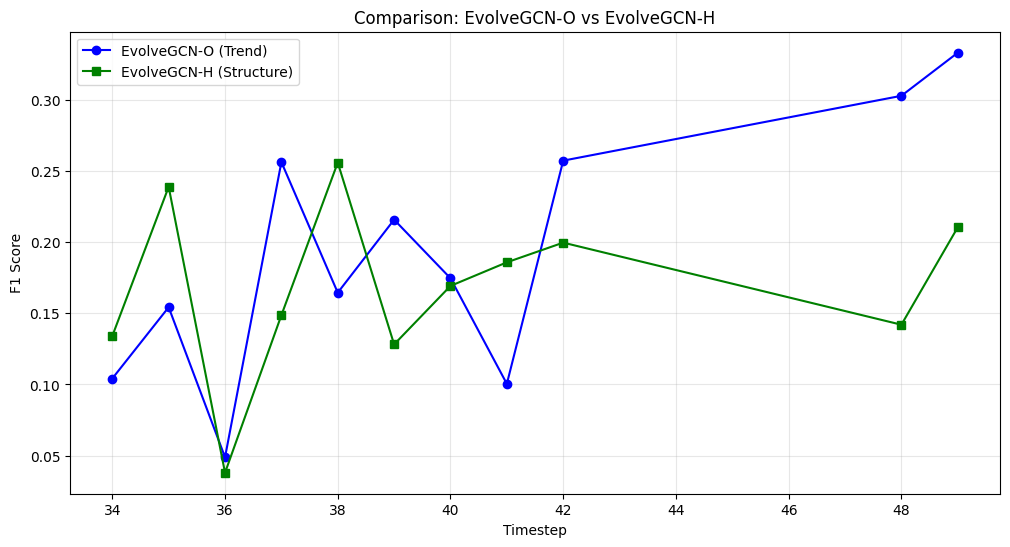


Summary Comparison (Test Set):
EvolveGCN-O Mean F1: 0.1921
EvolveGCN-H Mean F1: 0.1683


In [59]:
# Comparison Visualization
res_df_h = pd.DataFrame(test_results_h)

plt.figure(figsize=(12, 6))
plt.plot(res_df_o['timestep'], res_df_o['f1'], marker='o', label='EvolveGCN-O (Trend)', color='blue')
plt.plot(res_df_h['timestep'], res_df_h['f1'], marker='s', label='EvolveGCN-H (Structure)', color='green')

plt.title('Comparison: EvolveGCN-O vs EvolveGCN-H')
plt.xlabel('Timestep')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nSummary Comparison (Test Set):")
print(f"EvolveGCN-O Mean F1: {res_df_o['f1'].mean():.4f}")
print(f"EvolveGCN-H Mean F1: {res_df_h['f1'].mean():.4f}")